In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [46]:
df = pd.read_csv('dataset.csv')
X = df.drop('Unnamed: 0',axis=1)

In [47]:
X.head()

,Hidráulica,Eólica,Solar Fotovoltaica,Solar Térmica,Otras Renovables,Residuos Renovables,Nuclear,Turbinación bombeo,Ciclo combinado,Carbón,Fuel-gas,Cogeneración,Residuos no renovables,EUA SPOT,Demanda real,TTF GAS,Saldo Interconexiones,Price
0,2668.203,5788.224,0.050,15.815,359.722,186.340,7107.798,71.806,3775.267,5004.822,0.0,1527.712,149.386,6.99,24511.500000,20.275,-1773.906,48.10
1,2382.211,5368.731,0.045,15.799,358.945,187.789,7113.883,25.789,3452.924,4817.315,0.0,1515.046,148.494,6.99,22866.166667,20.275,-1942.838,47.33
2,1690.844,5150.656,0.051,15.774,351.918,186.181,7110.093,82.638,2907.244,4292.156,0.0,1514.132,151.826,6.99,21392.833333,20.275,-1165.379,42.27
3,1556.983,4835.700,0.043,7.862,347.058,178.637,7110.581,160.241,2721.058,3923.423,0.0,1513.983,147.574,6.99,20319.666667,20.275,-889.173,38.41
4,1510.068,4497.805,0.074,0.000,342.252,169.560,7110.582,233.965,2629.251,3655.118,0.0,1515.884,148.207,6.99,19923.000000,20.275,-294.821,35.72


In [48]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)

data = scaled_df.values

#utilizar ultimos datos de solar
#escalara la y con minmax

In [49]:
data.shape

(52606, 18)

In [50]:
n_steps = 168 # 168 horas son 7 dias

#Creamos grupos de 7 dias + 1 dia de nuestros datos
series_reshaped =  np.array([data[i:i + (n_steps+24)].copy() for i in range(len(data) - (n_steps+24))])

#series_reshaped es el dataframe subdividido en una array de grupos de filas de 192 (8 dias)
series_reshaped.shape

(52414, 192, 18)

In [51]:
#Alberto por que usa X_valid y X_test?

– Training set: A set of examples used for learning, that is to fit the parameters of the classifier.

– Validation set: A set of examples used to tune the parameters of a classifier, for example to choose the number of hidden units in a neural network.

– Test set: A set of examples used only to assess the performance of a fully-specified classifier.

In [52]:
#Coge los primeros 5 años. En subgrupos de 168 filas (7 dias)
X_train = series_reshaped[:43800, :n_steps]
#Hace lo mismo para el año 6.
X_valid = series_reshaped[43800:52414, :n_steps]

#Creamos un array vacio donde guardar los precios de la electricidad de las proximas 24 horas
Y = np.empty((52414, n_steps, 24))
#series_reshaped seleccionamos los precios de la electricidad con features 0
#de cada bloque de 168 de horas seleccionamos las siguientes 24 horas.
for step_ahead in range(1, 24 + 1):
    Y[..., step_ahead - 1] = series_reshaped[..., step_ahead:step_ahead + n_steps, 17]
    
#Idem que antes
Y_train = Y[:43800]
Y_valid = Y[43800:52560]

#the X training data is 168 hours of the past of all commodities, 
#and the Y training data is 24 hours of prices, into the future.

In [53]:
X_train.shape, Y_train.shape

((43800, 168, 18), (43800, 168, 24))

In [54]:
X_valid.shape, Y_valid.shape

((8614, 168, 18), (8614, 168, 24))

# SimpleRNN

In [55]:
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow import keras

In [56]:
es = EarlyStopping(monitor = 'val_loss')

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,18]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model6.compile(loss="mape", optimizer="adam")

In [58]:
history = model6.fit(X_train, Y_train, epochs=20,validation_data=(X_valid, Y_valid))

Epoch 1/20
1369/1369 [==============================] - 151s 110ms/step - loss: 1298.3960 - val_loss: 98.2682
Epoch 2/20
1369/1369 [==============================] - 67s 49ms/step - loss: 607.5964 - val_loss: 93.3789
Epoch 3/20
1369/1369 [==============================] - 42s 30ms/step - loss: 466.7235 - val_loss: 88.0753
Epoch 4/20
1369/1369 [==============================] - 42s 30ms/step - loss: 350.5874 - val_loss: 85.2848
Epoch 5/20
1369/1369 [==============================] - 42s 30ms/step - loss: 250.2636 - val_loss: 82.9781
Epoch 6/20
1369/1369 [==============================] - 42s 31ms/step - loss: 219.1961 - val_loss: 80.3372
Epoch 7/20
1369/1369 [==============================] - 42s 30ms/step - loss: 191.1115 - val_loss: 80.4311
Epoch 8/20
1369/1369 [==============================] - 42s 30ms/step - loss: 188.2479 - val_loss: 84.9488
Epoch 9/20
1369/1369 [==============================] - 42s 30ms/step - loss: 182.6570 - val_loss: 88.9112
Epoch 10/20
1369/1369 [===========

In [59]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

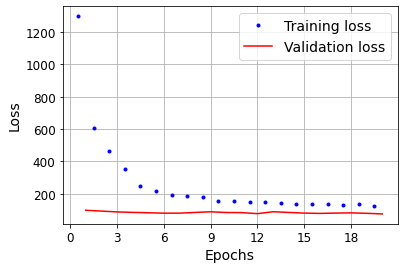

In [60]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data.

We will see this combination later on, but for now, see below a typical plot showing both metrics

In [61]:
Y_pred = model6.predict(X_valid)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_valid[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

In [63]:
actual[['actual', 'predictions','difference','difference_percentage']].mean()

actual                    0.336769
predictions               0.179830
difference                0.175197
difference_percentage    46.520979
dtype: float64

In [62]:
actual[['actual', 'predictions','difference','difference_percentage']]
#El modelo es una basura, pero es algo

,actual,predictions,difference,difference_percentage
0,0.610343,0.136205,0.474138,77.683863
1,0.608511,0.133907,0.474604,77.994307
2,0.595679,0.134949,0.460729,77.345289
3,0.582382,0.135148,0.447234,76.793954
4,0.592313,0.136749,0.455564,76.912698
...,...,...,...,...
8609,0.725877,0.110346,0.615531,84.798248
8610,0.718912,0.100604,0.618308,86.006028
8611,0.686537,0.115790,0.570746,83.134148
8612,0.657029,0.122066,0.534964,81.421591


# Simple Long-Short Term Memory Model

In [66]:
np.random.seed(42)
tf.random.set_seed(42)

model8 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 18]),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model8.compile(loss="mape", optimizer="adam")

In [67]:
historyLSTM = model8.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
1369/1369 [==============================] - 40s 29ms/step - loss: 413.4781 - val_loss: 97.3284
Epoch 2/20
1369/1369 [==============================] - 39s 29ms/step - loss: 204.6329 - val_loss: 87.4465
Epoch 3/20
1369/1369 [==============================] - 39s 29ms/step - loss: 135.4886 - val_loss: 69.0911
Epoch 4/20
1369/1369 [==============================] - 39s 29ms/step - loss: 106.0262 - val_loss: 62.9466
Epoch 5/20
1369/1369 [==============================] - 39s 29ms/step - loss: 83.1308 - val_loss: 62.8430
Epoch 6/20
1369/1369 [==============================] - 39s 29ms/step - loss: 75.0425 - val_loss: 52.3478
Epoch 7/20
1369/1369 [==============================] - 39s 29ms/step - loss: 66.3640 - val_loss: 48.3105
Epoch 8/20
1369/1369 [==============================] - 40s 29ms/step - loss: 62.8229 - val_loss: 45.2473
Epoch 9/20
1369/1369 [==============================] - 39s 28ms/step - loss: 65.9846 - val_loss: 51.7147
Epoch 10/20
1369/1369 [===================

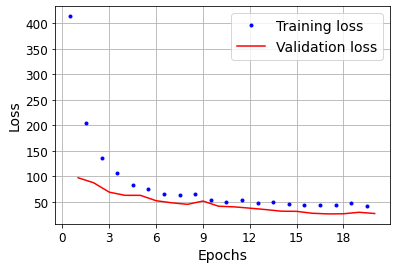

In [68]:
plot_learning_curves(historyLSTM.history["loss"], historyLSTM.history["val_loss"])
plt.show()

In [69]:
Y_pred = model8.predict(X_valid)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_valid[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('simplelstmresults.csv') 
# files.download('simplelstmresults.csv')

actual[['actual', 'predictions','difference','difference_percentage']].mean()
#El modelo es una basura, pero es algo

actual                    0.336769
predictions               0.010740
difference                0.326028
difference_percentage    95.707278
dtype: float64

In [70]:
actual[['actual', 'predictions','difference','difference_percentage']]

,actual,predictions,difference,difference_percentage
0,0.610343,0.003521,0.606822,99.423083
1,0.608511,0.003342,0.605168,99.450722
2,0.595679,0.003253,0.592426,99.453911
3,0.582382,0.003255,0.579126,99.441039
4,0.592313,0.003573,0.588740,99.396806
...,...,...,...,...
8609,0.725877,0.002047,0.723830,99.717954
8610,0.718912,0.001834,0.717078,99.744873
8611,0.686537,0.002343,0.684194,99.658793
8612,0.657029,0.003088,0.653941,99.529932


# Deep LSTM model

## Model9

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model9 = keras.models.Sequential([
    keras.layers.LSTM(80, return_sequences= True, input_shape=(168,18)),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(40, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(30, return_sequences= True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model9.compile(loss="mape", optimizer="adam")

In [25]:
history9 = model9.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid), callbacks = [es] )

Epoch 1/20
1369/1369 [==============================] - 164s 120ms/step - loss: 304.1299 - val_loss: 98.3917
Epoch 2/20
1369/1369 [==============================] - 162s 119ms/step - loss: 127.0555 - val_loss: 50.0738
Epoch 3/20
1369/1369 [==============================] - 164s 120ms/step - loss: 74.8132 - val_loss: 32.9611
Epoch 4/20
1369/1369 [==============================] - 164s 120ms/step - loss: 67.1038 - val_loss: 31.2681
Epoch 5/20
1369/1369 [==============================] - 165s 120ms/step - loss: 59.0991 - val_loss: 29.9313
Epoch 6/20
1369/1369 [==============================] - 165s 120ms/step - loss: 52.1481 - val_loss: 25.7202
Epoch 7/20
1369/1369 [==============================] - 160s 117ms/step - loss: 51.4669 - val_loss: 28.9055


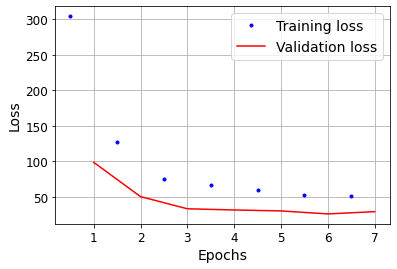

In [71]:
plot_learning_curves(history9.history["loss"], history9.history["val_loss"])
plt.show()

In [29]:
Y_pred = model9.predict(X_valid)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_valid[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('deeplstmresults.csv') 
# files.download('deeplstmresults.csv')

actual[['actual', 'predictions','difference','difference_percentage']].mean()
#El modelo es una basura, pero es algo

actual                    0.336769
predictions               0.000946
difference                0.335823
difference_percentage    99.638219
dtype: float64

In [30]:
actual[['actual', 'predictions','difference','difference_percentage']]

,actual,predictions,difference,difference_percentage
0,0.610343,0.000684,0.609659,99.887900
1,0.608511,0.000680,0.607831,99.888314
2,0.595679,0.000677,0.595001,99.886322
3,0.582382,0.000677,0.581705,99.883742
4,0.592313,0.000686,0.591627,99.884128
...,...,...,...,...
8609,0.725877,0.000681,0.725196,99.906142
8610,0.718912,0.000673,0.718240,99.906442
8611,0.686537,0.000689,0.685847,99.899575
8612,0.657029,0.000706,0.656323,99.892494


## Model10

In [35]:

np.random.seed(42)
tf.random.set_seed(42)

model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 18]),
    keras.layers.GRU(60, return_sequences=True),
    keras.layers.GRU(40, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])

model10.compile(loss="mape", optimizer="adam")

In [36]:
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]), callbacks = [es])

Epoch 1/20
1369/1369 [==============================] - 59s 43ms/step - loss: 574.2936 - val_loss: 91.4105
Epoch 2/20
1369/1369 [==============================] - 58s 43ms/step - loss: 294.5468 - val_loss: 73.1237
Epoch 3/20
1369/1369 [==============================] - 57s 41ms/step - loss: 234.8676 - val_loss: 50.3499
Epoch 4/20
1369/1369 [==============================] - 57s 41ms/step - loss: 153.3560 - val_loss: 45.5043
Epoch 5/20
1369/1369 [==============================] - 57s 41ms/step - loss: 117.1894 - val_loss: 44.7281
Epoch 6/20
1369/1369 [==============================] - 57s 42ms/step - loss: 106.6554 - val_loss: 39.1456
Epoch 7/20
1369/1369 [==============================] - 57s 42ms/step - loss: 103.7091 - val_loss: 37.1882
Epoch 8/20
1369/1369 [==============================] - 57s 42ms/step - loss: 87.9970 - val_loss: 32.8556
Epoch 9/20
1369/1369 [==============================] - 57s 42ms/step - loss: 90.9110 - val_loss: 37.6010


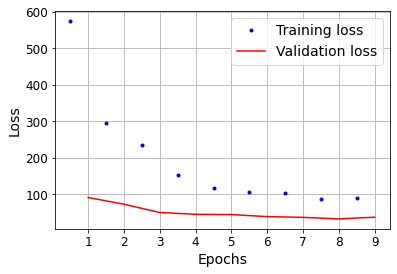

In [39]:
plot_learning_curves(history2.history["loss"], history2.history["val_loss"])
plt.show()

In [41]:
Y_pred = model10.predict(X_valid)
Y_pred.shape

(8614, 83, 24)

In [42]:
Y_pred = model10.predict(X_valid)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][3::2][0][23]))
    

actual = pd.DataFrame(X_valid[: , 0, 0])
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100

# from google.colab import files
# actual.to_csv('convlayerresults.csv') 
# files.download('convlayerresults.csv')

actual[['actual', 'predictions','difference','difference_percentage']].mean()
#El modelo es una basura, pero es algo

actual                    0.336769
predictions               0.127265
difference                0.231401
difference_percentage    66.185280
dtype: float64

In [43]:
actual[['actual', 'predictions','difference','difference_percentage']]

,actual,predictions,difference,difference_percentage
0,0.610343,0.000701,0.609642,99.885142
1,0.608511,0.000886,0.607624,99.854348
2,0.595679,0.000957,0.594722,99.839360
3,0.582382,0.001259,0.581122,99.783804
4,0.592313,0.001752,0.590561,99.704216
...,...,...,...,...
8609,0.725877,0.021218,0.704660,97.076932
8610,0.718912,0.017639,0.701273,97.546440
8611,0.686537,0.014456,0.672081,97.894418
8612,0.657029,0.009518,0.647512,98.551419
